<a href="https://colab.research.google.com/github/BaberFaisal/The-You-Are-What-You-Eat-Customer-Segmentation/blob/main/The_%22You_Are_What_You_Eat%22_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**The "You Are What You Eat" Customer Segmentation**

#**Table of Contents**
- Project Overview
  - Project Purpose
  - Context
  - Actions
  - Results
  - Growth/Next Steps
- Data Overview
- K-Means
  - Concept Overview
  - Data Preprocessing
  - Finding A Good Value For k
  - Model Fitting
  - Append Clusters To Customers
  - Cluster Profiling
- Application

#**Project Overview**
# Project Purpose
This project aims to segment the customer base using K-Means clustering to deepen business insights and improve the precision and effectiveness of targeted marketing and customer communications.


# Context
The leadership team at our client’s supermarket chain is currently divided on how lifestyle factors influence customer purchasing habits—specifically which food categories are being prioritized or neglected. They’ve tasked us with leveraging data and machine learning to segment customers based on their buying patterns across major food groups, to better understand their audience and refine their targeted marketing strategies.

# Actions
To begin, we compiled the required data from multiple sources within the database—specifically, the transactions and product_areas tables. Using Pandas, we merged and aggregated this data at the customer level, focusing on transaction activity over the most recent six-month period. For each customer, we calculated the percentage of total sales attributed to each product category, forming the foundation for our segmentation.

We then applied K-Means clustering to identify distinct customer segments based on purchasing behavior. Prior to modeling, we performed essential preprocessing steps such as feature scaling, which is critical for distance-based algorithms like K-Means to ensure comparability across variables.

Since K-Means is an unsupervised learning technique—meaning we do not have predefined labels—we utilized the Within-Cluster Sum of Squares (WCSS) method to determine the optimal number of clusters. After establishing this, we executed the clustering algorithm and assigned each customer to a segment. Finally, we analyzed and profiled each segment to identify the key behavioral characteristics that distinguish them.

# Results

Following iterative testing using the Within-Cluster Sum of Squares (WCSS) method, we identified a three-cluster solution as the most meaningful customer segmentation. The distribution of customers across these segments was notably uneven: Cluster 0 comprised the majority with 73.6% of the customer base, while Cluster 2 and Cluster 1 accounted for 14.6% and 11.8% respectively.

Profiling these clusters revealed insightful patterns in consumer behavior:

- Cluster 0 demonstrated a balanced distribution of spend across all product categories, suggesting a generalist group without strong dietary preferences.

- Cluster 1 showed disproportionately high spending on Fruit & Vegetables and minimal activity in Dairy and Meat—potentially indicative of a vegan customer segment.

- Cluster 2 reflected strong engagement with Dairy, Fruit & Vegetables, but low spending in the Meat category—suggesting a likely vegetarian preference.

To support adoption of this segmentation across the business, we’ve branded the model as the “You Are What You Eat” Segmentation, highlighting its focus on customer lifestyles and dietary choices.

# Growth/Next Steps
To deepen the segmentation analysis, a logical next step would be to perform clustering at a more granular level—using sub-categories within the main food groups such as Meat, Dairy, Fruit, and Vegetables. This would allow for more refined customer segments and a richer understanding of dietary habits and product preferences.

Additionally, the current segmentation is based solely on sales-related variables. By incorporating customer-level attributes such as gender, proximity to store, or household characteristics, we could develop a more holistic view of customer behavior and lifestyle.

Lastly, while k-means has been our primary method, exploring alternative clustering techniques such as Hierarchical Clustering or DBSCAN would provide a valuable benchmark, potentially revealing more complex structures or better-performing segmentations.



# Data Overview
Our primary objective is to identify distinct customer segments based on their transaction behavior within food-related product categories. To achieve this, we perform the following steps:

- Import Required Libraries: Begin by loading the necessary Python packages for data manipulation and analysis.

- Load Data: Import the relevant tables from the database, specifically the transactions and product_areas tables.

- Merge Datasets: Join the transaction data with product metadata to append product_area_name to each transaction.

- Filter for Food Categories: Exclude any non-food product areas to focus solely on dietary-related purchases.

- Aggregate Sales by Customer: Summarize transaction data to compute total spend per product area for each customer.

- Reshape the Data: Pivot the aggregated data to structure it in a customer-by-product-area format suitable for clustering.

- Normalize Spending: Convert absolute spending figures into percentage allocations to normalize spending behavior across customers and ensure comparability.

This processed dataset then serves as the foundation for applying clustering algorithms to uncover meaningful customer segments.

In [ ]:
# import required Python packages
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

# import tables from database
transactions = pd.read_excel('/content/grocery_database .xlsx', sheet_name='transactions')
product_areas = pd.read_excel('/content/grocery_database .xlsx', sheet_name='product_areas')

# merge data on product area id
transactions = pd.merge(transactions, product_areas, how='inner', on='product_area_id')

# drop the non-food category
transactions.drop(transactions[transactions['product_area_name'] == 'Non-Food'].index, inplace=True)

# aggregate sales at customer level by product area
transactions_summary = transactions.groupby(['customer_id', 'product_area_name'])['sales_cost'].sum()

# pivot data to place product area as columns
transactions_summary_pivot = transactions.pivot_table(index='customer_id',
                                                      columns='product_area_name',
                                                      values='sales_cost', aggfunc='sum',
                                                      fill_value=0, margins=True,
                                                      margins_name='Total').rename_axis(None, axis=1)

# turn sales into % sales
transactions_summary_pivot = transactions_summary_pivot.div(transactions_summary_pivot['Total'], axis=0)

# drop the total column
data_for_clustering = transactions_summary_pivot.drop(['Total'], axis=1)

In [ ]:
data_for_clustering.head()

,Dairy,Fruit,Meat,Vegetables
customer_id,,,,
1,0.271547,0.203804,0.401244,0.123405
2,0.246200,0.197656,0.394250,0.161894
3,0.142496,0.232527,0.527821,0.097156
4,0.341088,0.244770,0.272134,0.142008
5,0.212754,0.249691,0.430338,0.107218


#K-Means

###**Concept Overview**

K-Means Clustering is an unsupervised machine learning technique designed to identify patterns in unlabelled datasets by grouping similar data points into distinct clusters.

The core idea behind the algorithm is to partition data points into "k" clusters based on their similarity, which is typically measured using Euclidean distance in an n-dimensional space—each variable representing a dimension.

The process follows these iterative steps:

- Initialization: Randomly select k initial points in the data space, known as centroids.

- Assignment: Assign each data point to the closest centroid based on Euclidean distance.

- Update: Recalculate the position of each centroid by taking the mean of all data points assigned to it.

- Reassignment: Reassign each point to the nearest updated centroid.

Steps 3 and 4 repeat until the assignments no longer change, indicating convergence. The final result is a set of clusters where each group contains data points that are more similar to each other than to those in other clusters.





###**Data Preprocessing**

Before applying the K-Means algorithm, it's crucial to address three key preprocessing areas: missing values, outliers, and feature scaling. These factors directly influence the quality and reliability of the clustering output.

1. Handling Missing Values
K-Means relies on calculating distances across all dimensions (features), so missing values can disrupt this process. When a value is absent, the algorithm cannot determine its position in the feature space. The two typical approaches are:

- Dropping rows with missing values

- Imputing missing values using statistical methods (mean, median, or model-based)

In our case, the data is aggregated at the customer level and doesn't contain missing values—so no imputation is necessary.

2. Addressing Outliers
Since K-Means uses distance-based metrics (typically Euclidean), outliers can distort clustering results. A single extreme value can skew the distribution and disproportionately influence centroid calculations.

The issue is particularly critical when scaling features, as variables influenced by outliers can compress the scale of others, reducing their impact on the clustering.

Fortunately, our data represents percentages of spend per product area, which naturally fall within a consistent range (0 to 1). As such, extreme outliers are not a concern in this scenario.

3. Feature Scaling
Because K-Means measures distance in a multidimensional space, all variables must be on the same scale to ensure fair comparison. Without scaling, features with larger numerical ranges could dominate the clustering process.

There are two widely used scaling techniques:

- Standardization (z-score normalization): Rescales features to have a mean of 0 and standard deviation of 1.

- Normalization (Min-Max Scaling): Rescales features to a range between 0 and 1.

In our case, normalization is more appropriate for two reasons:

- It ensures uniformity across variables regardless of their distribution.

- Our percentage-based inputs already fall between 0 and 1, but applying normalization helps distribute even low-volume product categories proportionally, preventing any dominant category from skewing the results.

We apply normalization using MinMaxScaler from scikit-learn and store the scaled output separately. This way, we preserve the original percentage values for easier interpretation when profiling the resulting clusters.







In [ ]:
# create our scaler object
scale_norm = MinMaxScaler()

# normalise the data
data_for_clustering_scaled = pd.DataFrame(scale_norm.fit_transform(data_for_clustering), columns = data_for_clustering.columns)

###**Finding A Good Value For k**
With the data now preprocessed and ready for modeling, the next key step is to identify an appropriate value for k, the number of clusters. Unlike supervised learning, unsupervised methods like K-Means do not provide an obvious ground truth—making the selection of k a nuanced process.

From a business perspective, it's important to strike a balance: too few clusters might oversimplify the diversity within the customer base, while too many could overwhelm stakeholders with overly granular insights that are difficult to interpret and act upon.

Although selecting k can sometimes be subjective, there are quantitative techniques that can guide us. One widely adopted method is the Within-Cluster Sum of Squares (WCSS). This metric captures the total squared distance between each data point and its assigned cluster centroid—effectively measuring how compact the clusters are.

As we increase the value of k, WCSS will naturally decrease, since more centroids allow for tighter grouping of data. However, the key insight lies in identifying the "elbow point"—the value of k beyond which additional clusters yield diminishing returns in reducing WCSS. This point helps us balance model complexity with clustering effectiveness.

By default, Scikit-learn sets k = 8, but this may not align with our use case. To find a more suitable value, we run the K-Means algorithm for multiple values of k, track the corresponding WCSS, and visualize the results using an elbow plot. This plot allows us to detect where improvements begin to taper off—guiding our choice of an optimal k for business application.

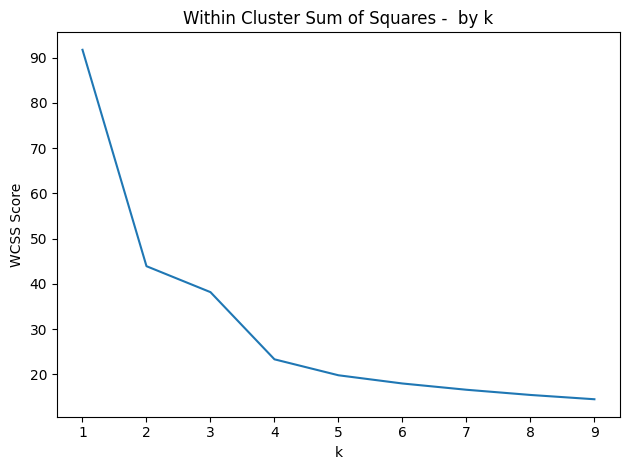

In [ ]:
# set up range for search, and empty list to append wcss scores to
k_values = list(range(1,10))
wcss_list = []

# loop through each possible value of k, fit to the data, append the wcss score
for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(data_for_clustering_scaled)
    wcss_list.append(kmeans.inertia_)

# plot wcss by k
plt.plot(k_values, wcss_list)
plt.title("Within Cluster Sum of Squares -  by k")
plt.xlabel("k")
plt.ylabel("WCSS Score")
plt.tight_layout()
plt.show()

Upon reviewing the WCSS elbow plot, a clear inflection point emerges at k = 3. Up to this value, the reduction in WCSS is substantial, indicating meaningful improvements in cluster compactness. Beyond this point, the incremental gains in clustering performance begin to taper off—suggesting diminishing returns from adding more clusters.

This evidence supports the decision to proceed with three customer segments, striking a balance between analytical rigor and business practicality. A smaller number of well-defined clusters not only simplifies interpretation but also facilitates clearer communication and targeted strategy development across business teams.

Accordingly, we move forward by applying the K-Means algorithm using k = 3, and will subsequently analyze and profile the resulting segments to derive actionable insights.

###**Model Fitting**
The below code will instantiate our k-means object using a value for k equal to 3. We then fit this object to our scaled dataset to separate our data into three distinct segments or clusters.

In [ ]:
# instantiate our k-means object
kmeans = KMeans(n_clusters = 3, random_state = 42)

# fit to our data
kmeans.fit(data_for_clustering_scaled)

KMeans(n_clusters=3, random_state=42)

###**Append Clusters To Customers**
After fitting the k-means algorithm to our dataset, we can assign each customer to the cluster they most closely align with, based on their spending patterns across product areas. In the following code, we append the corresponding cluster labels to the original dataframe.

In [ ]:
# add cluster labels to our original data
data_for_clustering["cluster"] = kmeans.labels_

###**Cluster Profiling**
After dividing the data into distinct clusters, it's essential for our client to identify the key characteristics that differentiate each group. This insight enables the business to better understand the customers in each segment and the behaviors that define them.

###**Cluster Sizes**
The code below helps us evaluate how many customers belong to each cluster.

In [ ]:
# check cluster sizes
data_for_clustering["cluster"].value_counts(normalize=True)

,proportion
cluster,
0,0.413318
1,0.349024
2,0.237658


Running the code reveals that the three clusters vary in size, with the following distribution:

- Cluster 0: 73.6% of the customer base

- Cluster 2: 14.6% of the customer base

- Cluster 1: 11.8% of the customer base

These results indicate a notable skew toward Cluster 0, while Clusters 1 and 2 are relatively smaller. This isn’t necessarily positive or negative. it simply highlights distinct segments of customer behavior, which aligns perfectly with our objective.

###**Cluster Attributes**
To gain insight into the unique characteristics of each segment, we now analyze the underlying features used in the k-means clustering process.



In [ ]:
# profile clusters (mean % sales for each product area)
cluster_summary = data_for_clustering.groupby("cluster")[["Dairy","Fruit","Meat","Vegetables"]].mean().reset_index()
cluster_summary

,cluster,Dairy,Fruit,Meat,Vegetables
0,0,0.238214,0.208101,0.414547,0.139139
1,1,0.212664,0.335928,0.314645,0.136763
2,2,0.181841,0.523302,0.002625,0.292231


For Cluster 0, we observe a fairly balanced distribution of spending across all product areas, indicating no clear dietary preference.

Cluster 1 exhibits high spending in Fruit & Vegetables, with minimal spend in Dairy and Meat, suggesting that these customers may follow a vegan diet.

Meanwhile, customers in Cluster 2 tend to allocate a large share of their spending to Dairy, Fruit & Vegetables, but spend very little on Meat, leading to an early assumption that they may be vegetarians — a compelling insight.



###**Application**
While this segmentation is relatively simple and built on broad product categories, it provides valuable clarity to business leaders and category managers about customer behavior.

Monitoring how these clusters evolve over time can help the client stay attuned to emerging dietary trends and adapt marketing and inventory strategies accordingly.

With these customer segments, the client can adopt a more targeted approach — offering promotions and product suggestions that align with actual customer preferences, ultimately supporting a more personalized and customer-centric communication strategy.